# Part 3 : Modelling Spread of Rumours through Echo Chambers

## Phenomena to be modelled & simulated

Why are we seeing a sudden rise in the spread of fake news? How did facebook play a role in influencing the 2016 presedential selections? Are opinions taking precedence over facts in todays online world?

With some of these questions in mind, this section is attempting to model and simulate the effect that echo chambers have on the spread of rumours and fake news in online social networks. Echo chambers effect occurs when people are exposed situations that conform their opinions and interact with people that have similar interests and agree with their opnions. 

There are certain signs that point to a link between these two phenomena—echo chambers and the spread of misinformation—since homogeneous clusters of users with a preference for self-confirmation seem to provide capable green-houses for the seedling of rumors and misinformation [7]. A polarized digital space where users tend to promote their favorite narratives, form polarized groups and resist information that does not conform to their beliefs may be the fertilizer that makes the Internet so fertile for the growth of misinformation. Therefore, echo chambers reinforce existing perspectives and foster confirmations biases[5]. In the following section, we attempt to build network simulation models to study the effect of such opinion and network polarised clusters on the virality of a misinformation. 

## Conceptual Model

In the network modelling of this phenomena, we simulate a network where the nodes are the people belonging to the network and the edges between the nodes indicate the other people in the network to whom they are connected with. 

We then simulate an echo chamber within this network, which is a cluster of closely connected nodes such that its intra-cluster connectivity is maximised and inter-cluster connectivity is minimised. The users in the echo-chamber are characterised by 2 properties: opinion and network polarisation. 

Opinion polarization means that they, in relation to a given question, are more inclined to share similar views. 

Network polarization means that they are more densely connected with each other than with the outside network. In other words, an echo chamber is a tightly connected set of nodes more inclined to share a common view on a given narrative. For the sake of simplicity, this model focuses on the existence of a single echo-chamber in a larger network.

The second aspect of the echo chambers, opinion polarization, implies that their thresholds are lower than that of the surrounding network. This henomena is desribe in network terms as homophily: the probability that neighboring nodes have similar thresholds for activation. 

In [948]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import numpy as np
from networkx.algorithms import community
import random

**Exercise 1 :** Write a helper funtion to draw a network using networkx and color the nodes to which the information has spread in blue and the remaining nodes in green

In [1170]:
def draw_activated_nodes(G):
    color_map = []
    for node in G:
        if G.nodes[node]['status'] == 'activated':
            color_map.append('orange')
        else: color_map.append('green')      
    nx.draw(G,node_color = color_map,with_labels = True)
    plt.show()
    

**Exercise 2 :** Replicate the 'draw_activate_nodes' function, but instead the blue nodes should represent the nodes that belong to the echo chamber

In [964]:
def draw_echo_chamber(G, echo_chamber):
    color_map = []
    for node in G:
        if node in echo_chamber:
            color_map.append('blue')
        else: color_map.append('green')      
    nx.draw(G, node_color = color_map,with_labels = True)
    plt.show()

**Exercise 3 :** Given a network of nodes and edges, construct an 'echo-chamber' within the network. The parameters and their role in the echo chamber is defined below.

Run the function on random Erdős-Rényi network and visualise the nodes

Each node in the network is assigned a threshold value. The threshold value indicates the minimum percentage of neighbors who need to believe in an information, for the node/ person to believe in that information.

Variable definitions are:

N = Number of nodes in the network

E = Number of edges in the network

c = Fraction of nodes that belong to the echo chamber (0.2)

k = average degree of the nodes

θ = Threshold of nodes outside the echo chamber

θ − P<sub>0</sub> = Threshold of nodes inside the echo chamber


1. Select cN nodes from the network
2. Select P<sub>n</sub> kE edges from this set such that exactly one of the connected nodes belong to the cluster. These are removed, and replaced by edges where both nodes belong to the cluster. 
3. Nodes outside the cluster are set to have activation threshold θ, and nodes in the cluster are set to have threshold θ − P<sub>0</sub>.

In [1128]:
def create_echo_chamber(G, nw_polarisation, opinion_polarisation, viz =0):    
    echo_chamber_size = int(0.20*G.number_of_nodes())
    echo_chamber = random.sample(G.nodes(), echo_chamber_size)
    
    N = G.number_of_nodes()
    E = G.number_of_edges()
    avg_degree = E / float(N)

    if(viz==1):
        print("Random nodes selected for the echo chamber")
        draw_echo_chamber(G, echo_chamber)
    modified_edge_count = 0 

    external_edge_cnt = 0
    for node in echo_chamber:
        nghbrs = list(G.neighbors(node))
        for neighbor in nghbrs:
            if(neighbor not in echo_chamber):
                external_edge_cnt = external_edge_cnt + 1
    for node in echo_chamber:
        G.nodes[node]['threshold'] =  G.nodes[node]['threshold'] - opinion_polarisation
        nghbrs = list(G.neighbors(node))
        for neighbor in nghbrs:
            if modified_edge_count >= (nw_polarisation *external_edge_cnt ):
                break;
            if(neighbor not in echo_chamber):
                G.remove_edge(node, neighbor)
                new_neighbor = random.choice(echo_chamber);
                while(G.has_edge(node, new_neighbor) or node==new_neighbor):
                    new_neighbor = random.choice(echo_chamber)
                G.add_edge(node, new_neighbor)
                modified_edge_count = modified_edge_count + 1

    if(viz == 1):
        print("Echo Chamber post modification of the edges")
        draw_echo_chamber(G, echo_chamber)
    return G, echo_chamber


Random nodes selected for the echo chamber


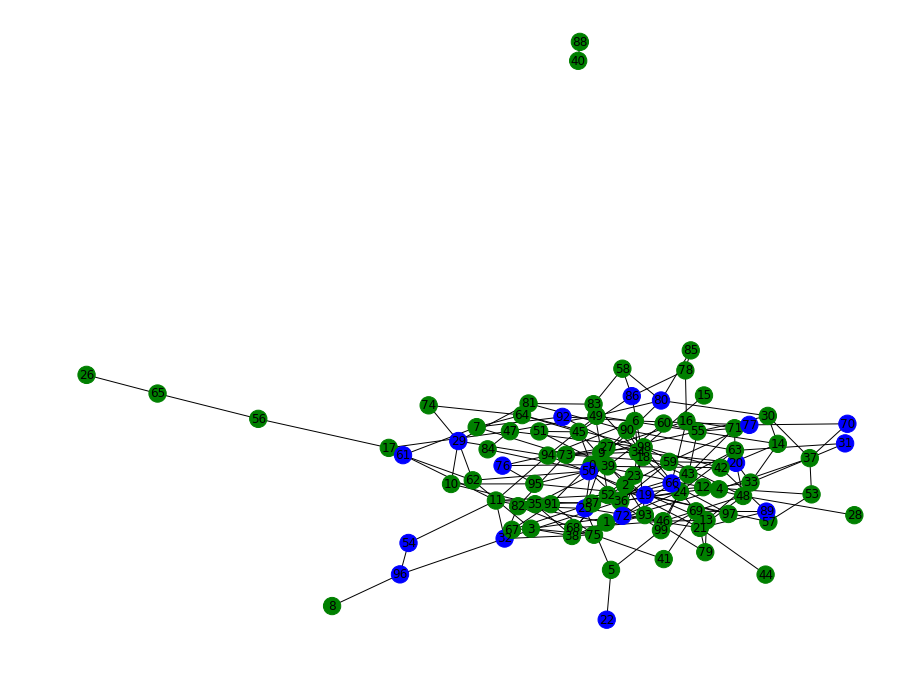

Echo Chamber post modification of the edges


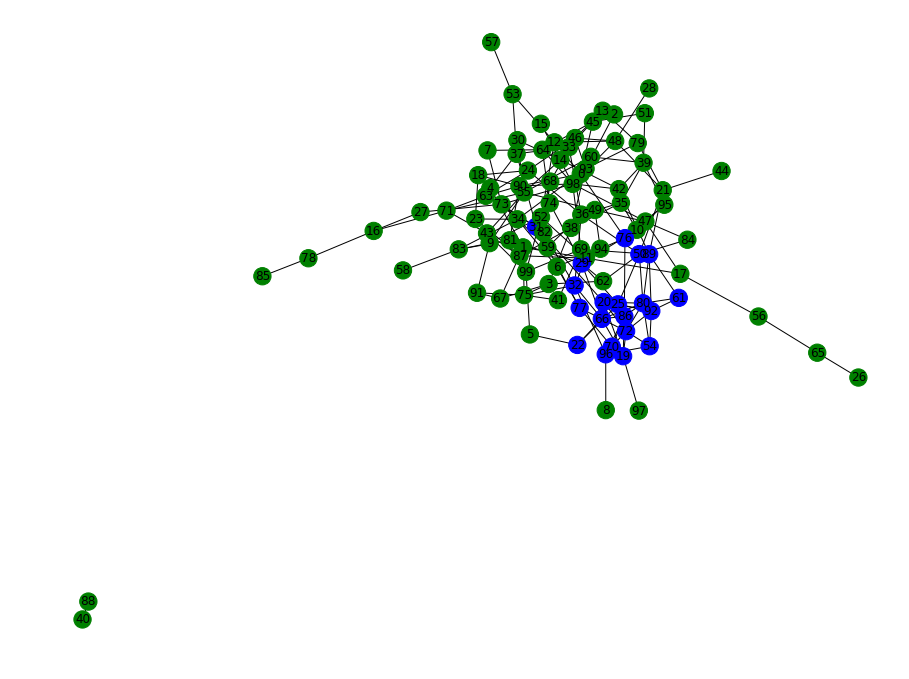

In [1144]:
G = nx.erdos_renyi_graph(100, 0.04)
status = 'healthy'
threshold = 0.27
nx.set_node_attributes(G, status, 'status')
nx.set_node_attributes(G, threshold, 'threshold')

grph, ec = create_echo_chamber(G, 0.6, 0.05, 1)

**Exercise 4:** Write a function to model the spread of information starting from a random node in the echo chamber. The parameter that are taken as input to the function are:
1. Network Polarisation: Factor by which nodes in the echo chamber are more tightly connected within other nodes in the chamber as compared to nodes outside it
2. N = Number of nodes
3. Opinion Polarisation: Factor by which the threshold of nodes in the echo chamber is less than the other nodes
4. Threshold: % of neighbors that believe in the information for a node to believe in it too
5. niter: Number of iterations


In [1183]:

def model_information_diffusion(nw_polarisation, N, opinion_polarisation, threshold, niter, viz = 0):
    res = []
    for i in range(niter):
        G = nx.erdos_renyi_graph(N, 0.04)
        status = 'healthy'
        nx.set_node_attributes(G, status, 'status')
        nx.set_node_attributes(G, threshold, 'threshold')
        if(viz == 1):
            print("Initial Network")
            draw_activated_nodes(G)
            G, echo_chamber = create_echo_chamber(G, nw_polarisation, opinion_polarisation, 1)
        else:
            G, echo_chamber = create_echo_chamber(G, nw_polarisation, opinion_polarisation)

        # Start information spread
        activator_node = random.choice(echo_chamber)
        
        G.nodes[activator_node]['status'] = "activated"
        if(viz == 1):
            print("Start of the Spread of Information")
            draw_activated_nodes(G)
        for neighbor in G.neighbors(activator_node):
            G.nodes[neighbor]['status'] = "activated"
        while True:
            prev_status = nx.get_node_attributes(G, 'status')
            for node in list(G.nodes):
                act_count = 0
                if G.nodes[node]['status'] != "activated":
                    status = nx.get_node_attributes(G, 'status')
                    neighbor_count = len(list(G.neighbors(node)))
                    for neighbor in G.neighbors(node):
                        if status[neighbor] == "activated":
                            act_count = act_count + 1
                    if act_count > (neighbor_count *  G.nodes[node]['threshold'] ) and act_count!=0:
                        G.nodes[node]['status'] = "activated"
                        if(viz == 1):
                            #print("Final Spread of Information")
                            draw_activated_nodes(G)
            curr_status = nx.get_node_attributes(G, 'status')
            matches = len([i for i, j in zip(prev_status.values(), curr_status.values()) if i == j]) 
            # Stop if no change in node status observed
            if matches == G.number_of_nodes():
                break
        if(viz == 1):
            print("Final Spread of Information")
            draw_activated_nodes(G)

        status = nx.get_node_attributes(G, 'status')
        res.append(round(sum( x == 'activated' for x in status.values() )/ N, 4))
    return res


Initial Network


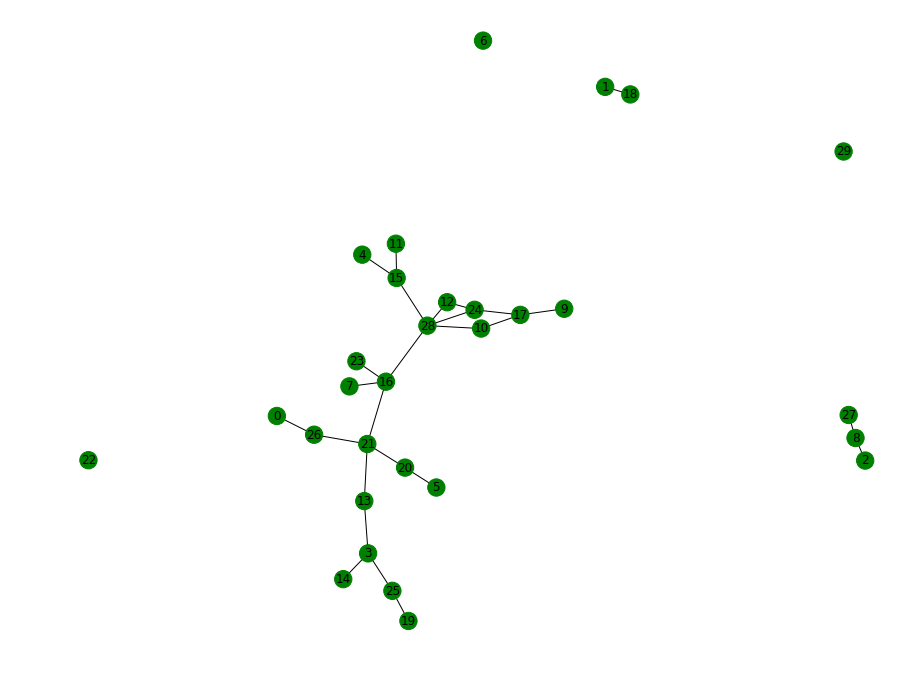

Random nodes selected for the echo chamber


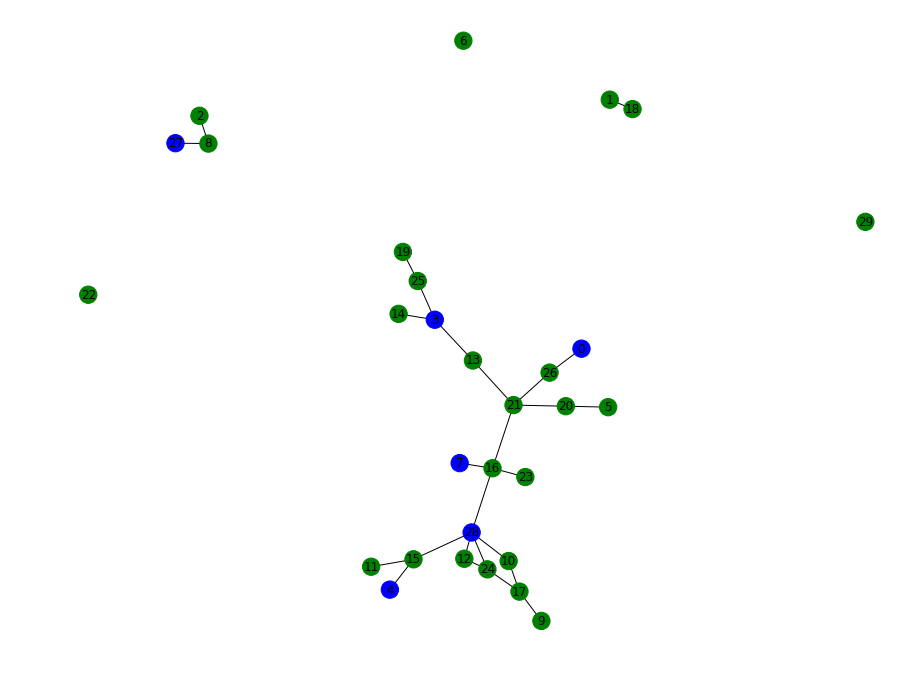

Echo Chamber post modification of the edges


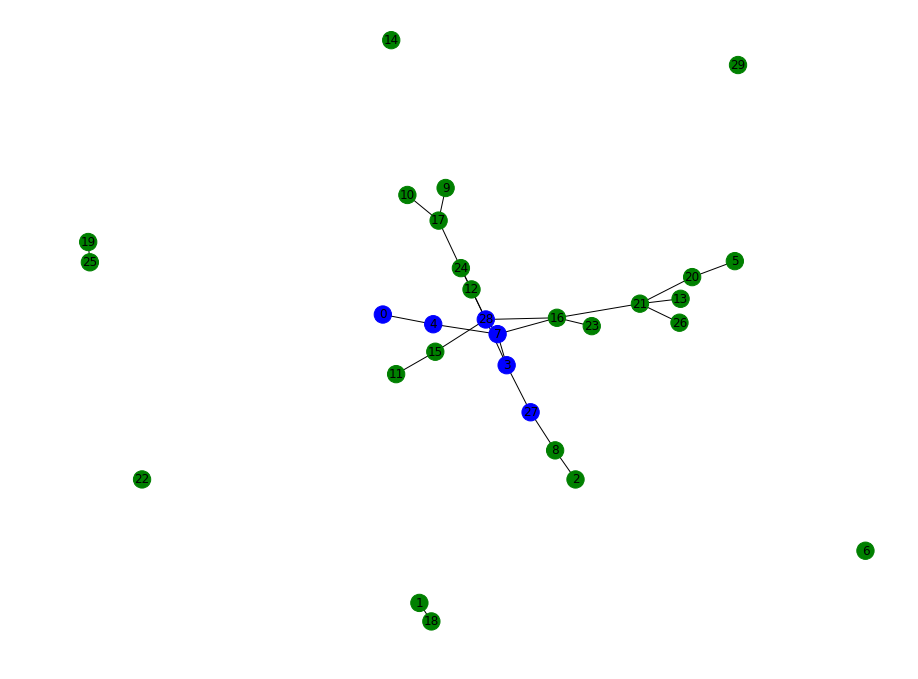

Start of the Spread of Information


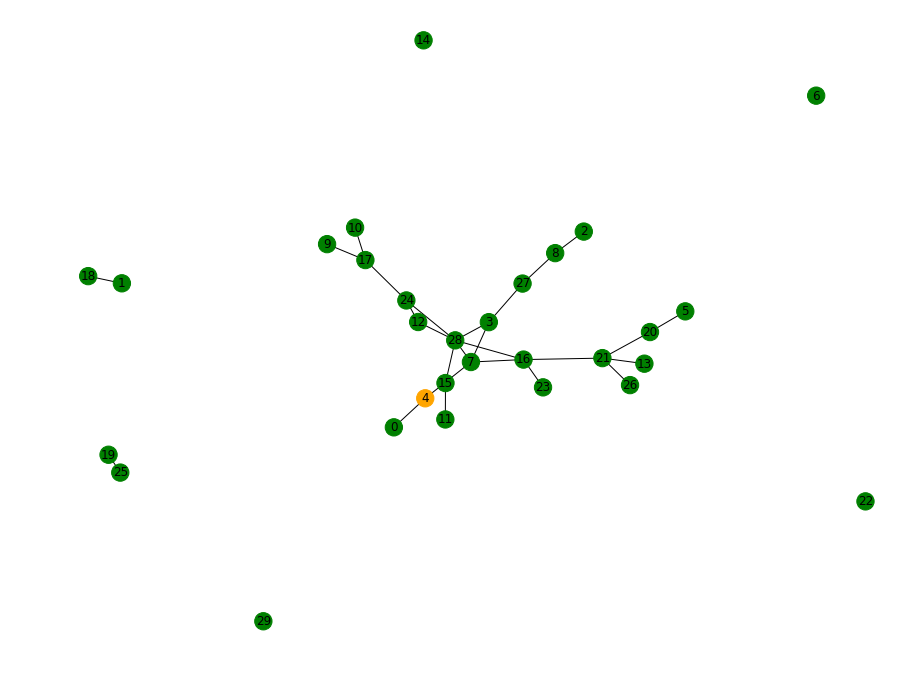

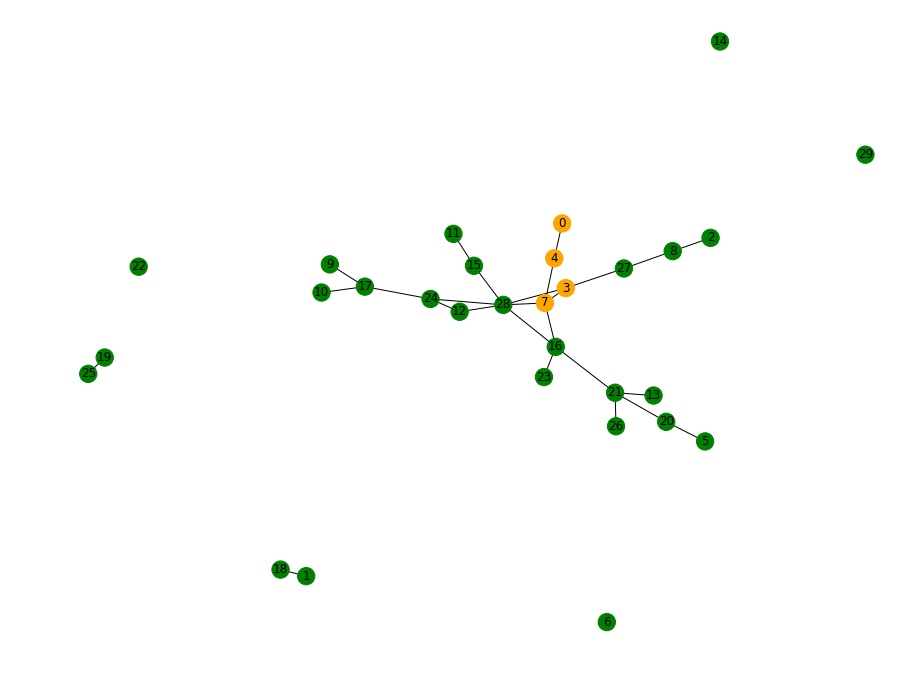

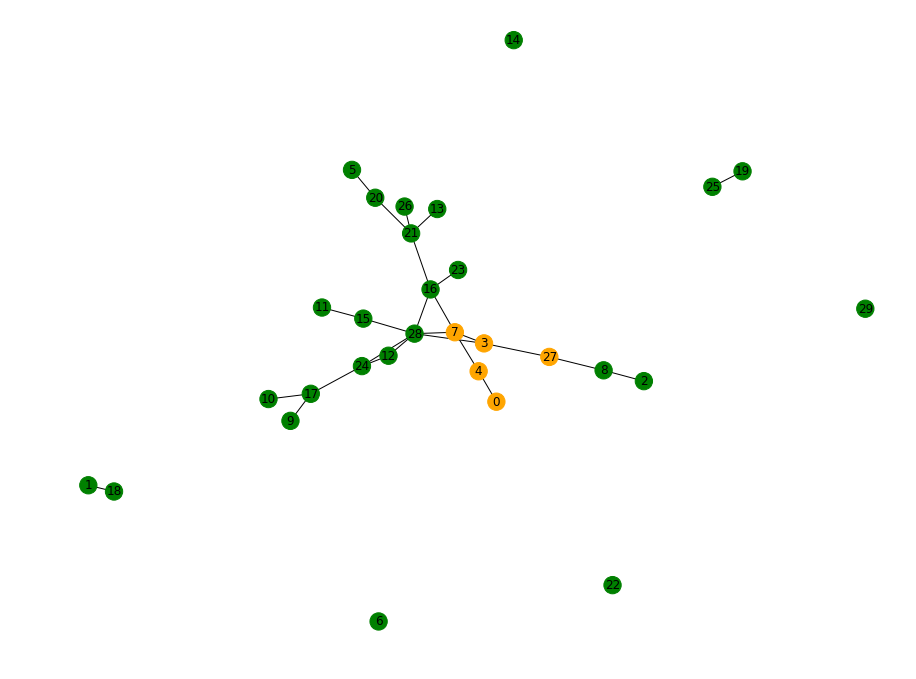

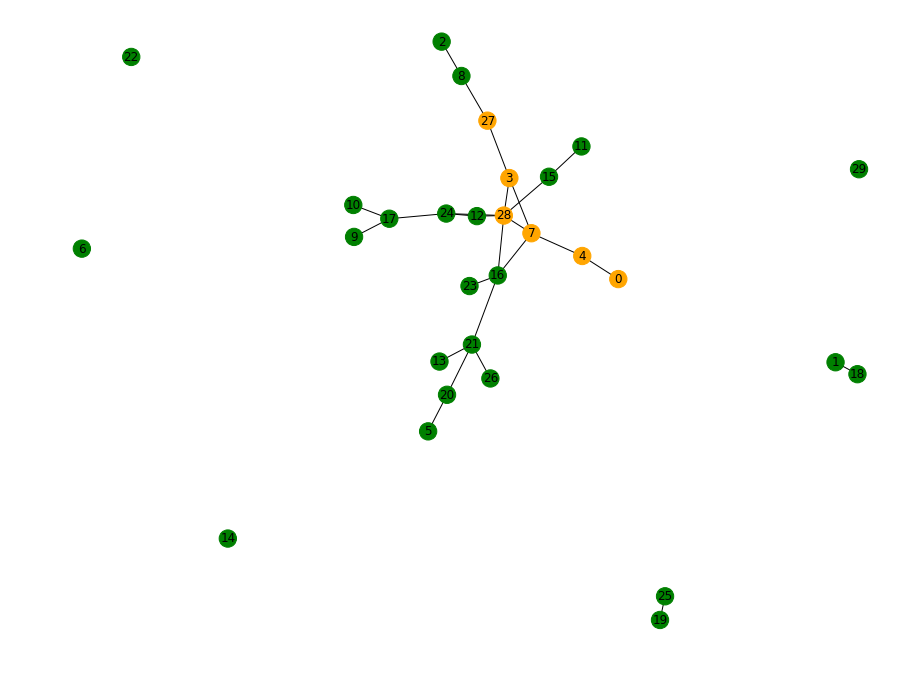

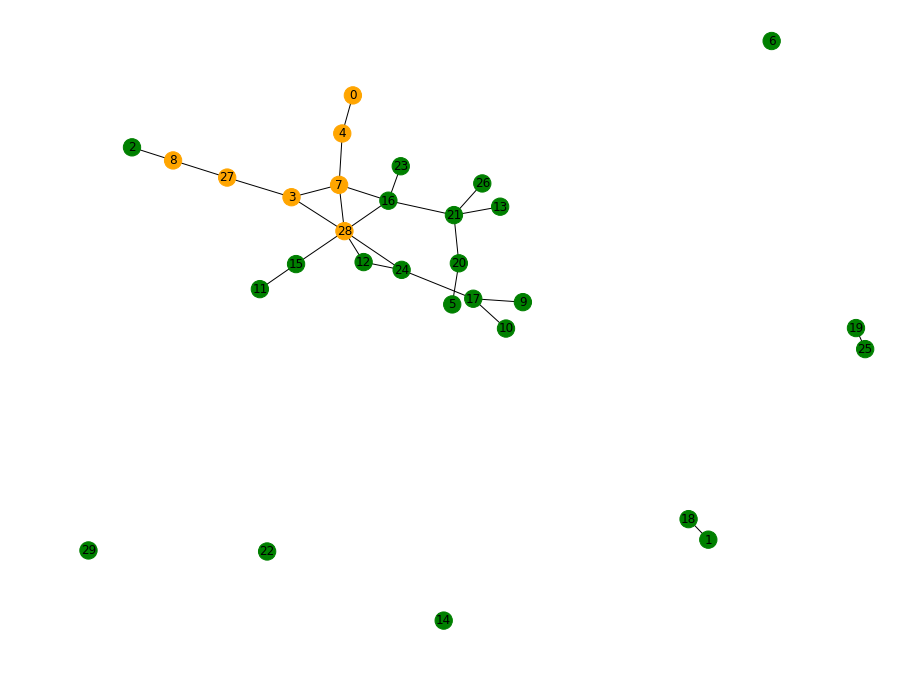

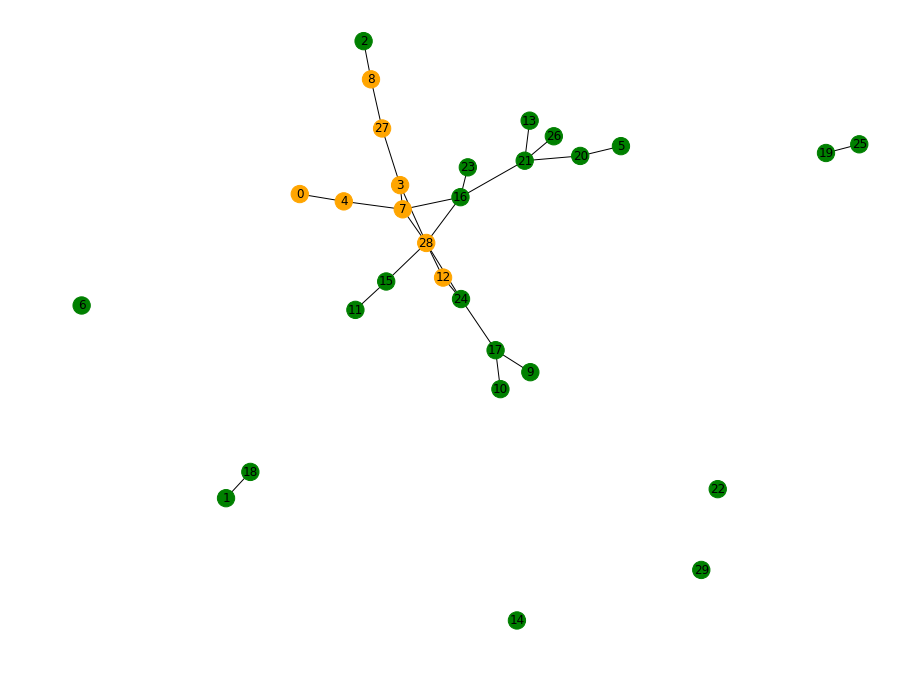

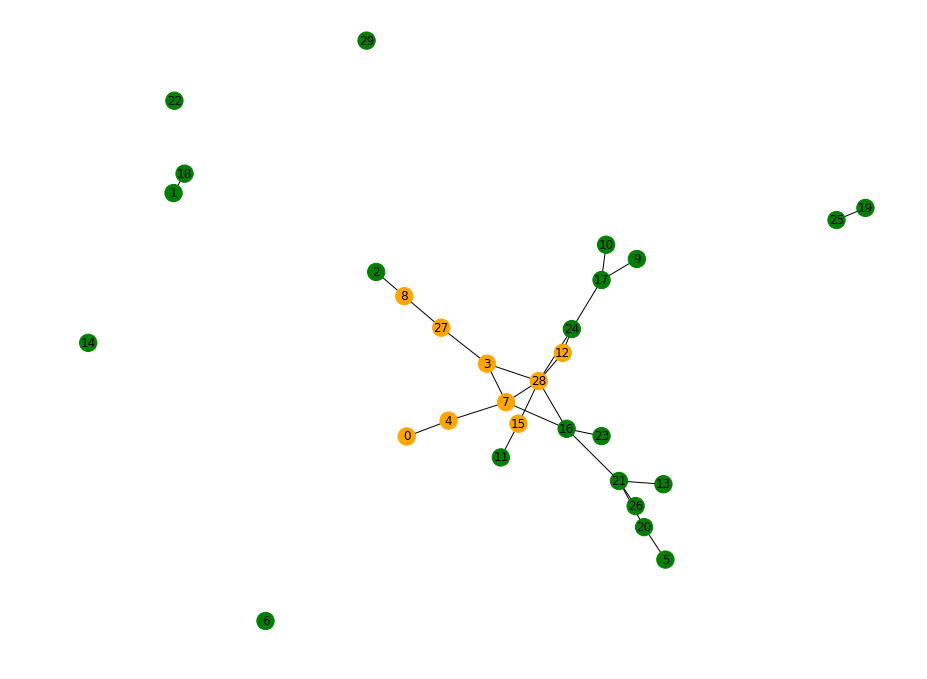

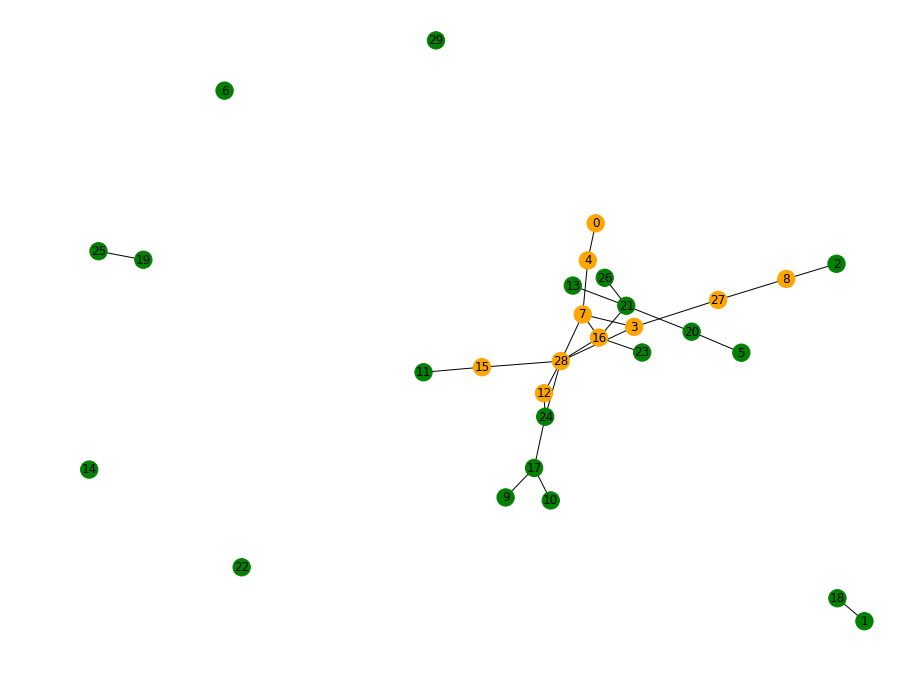

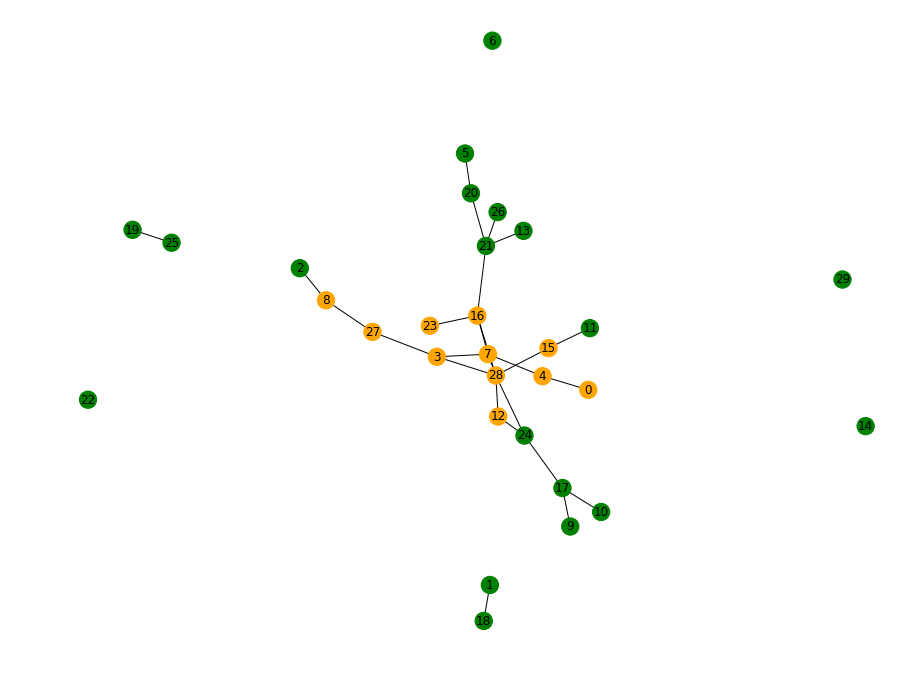

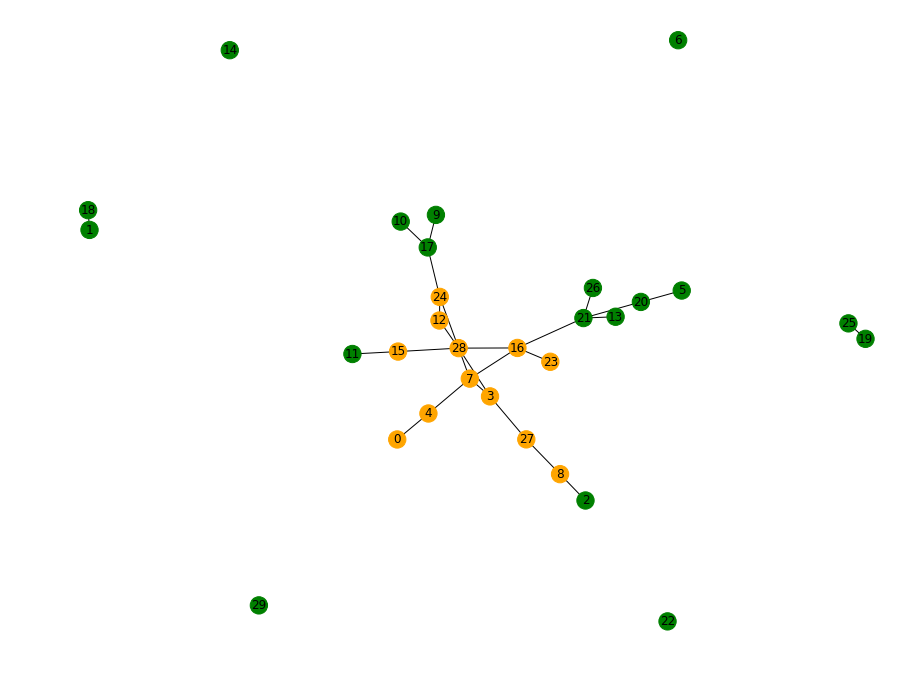

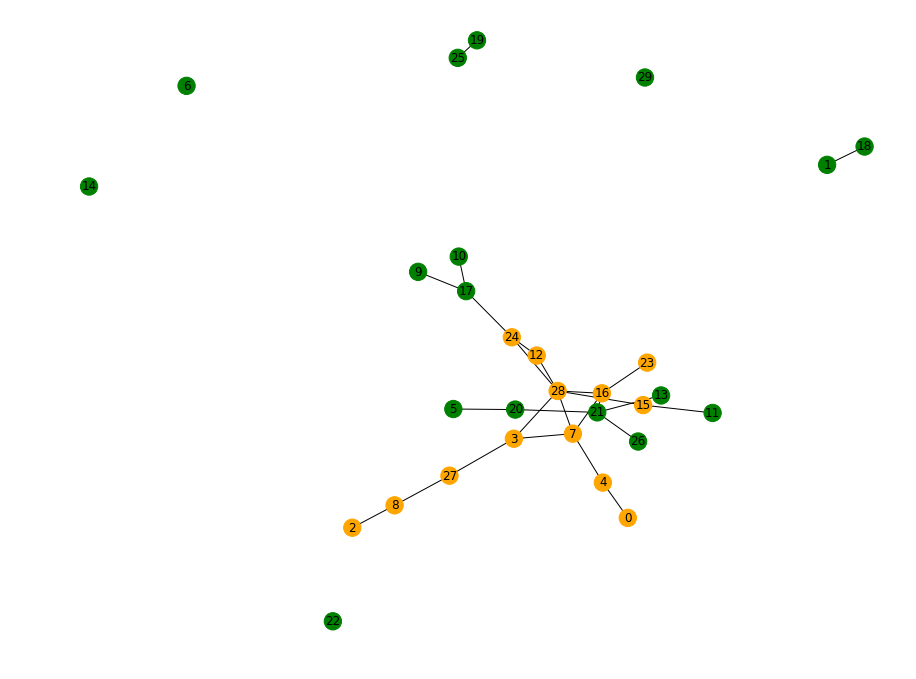

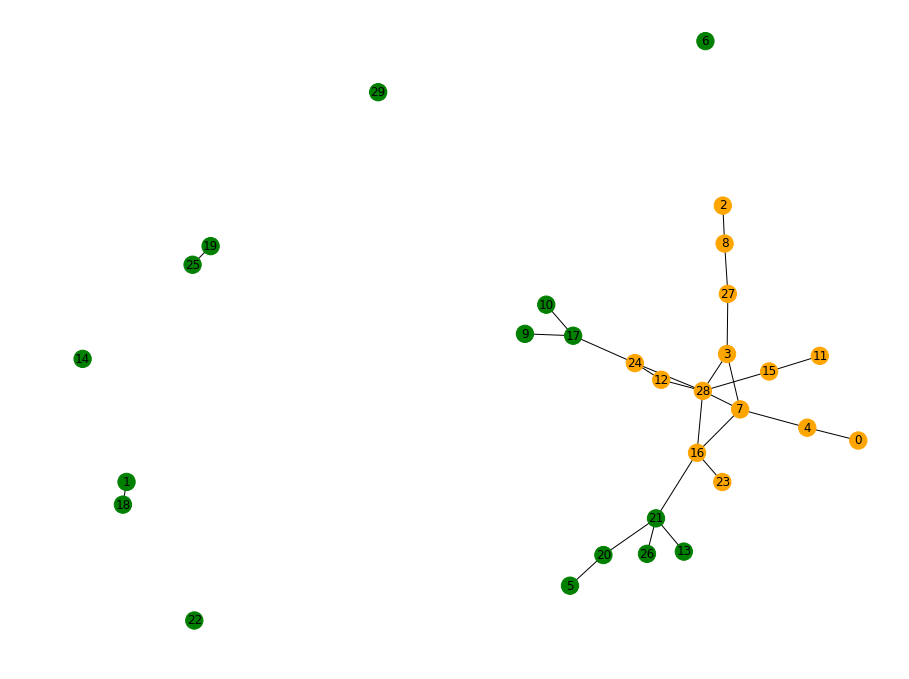

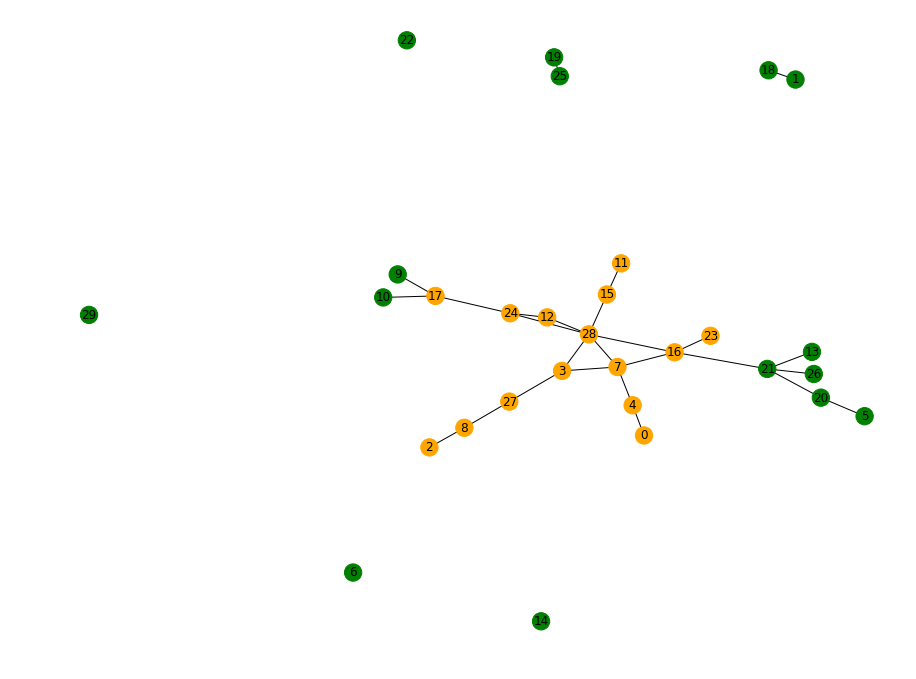

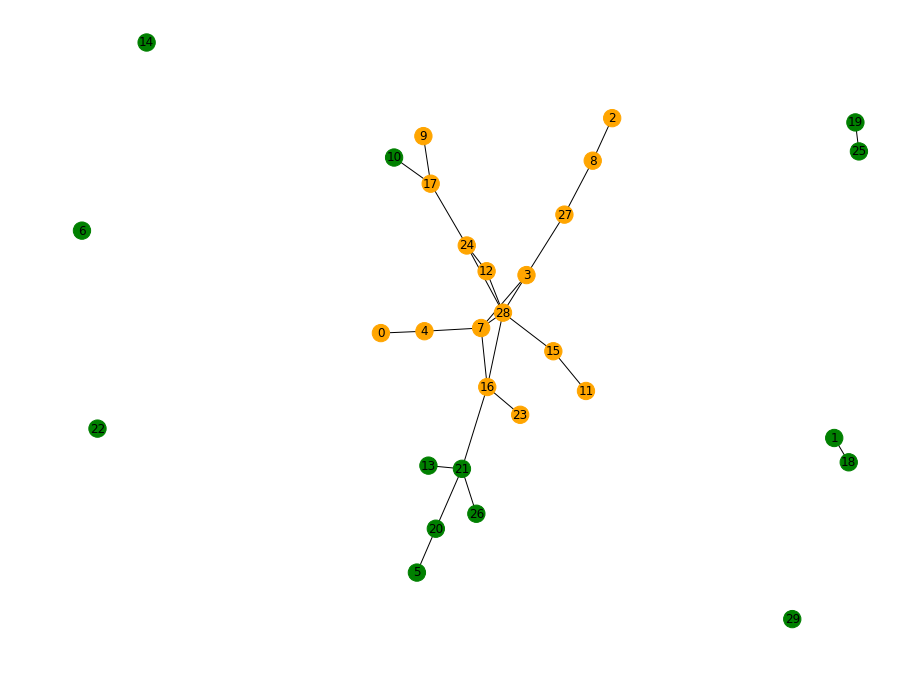

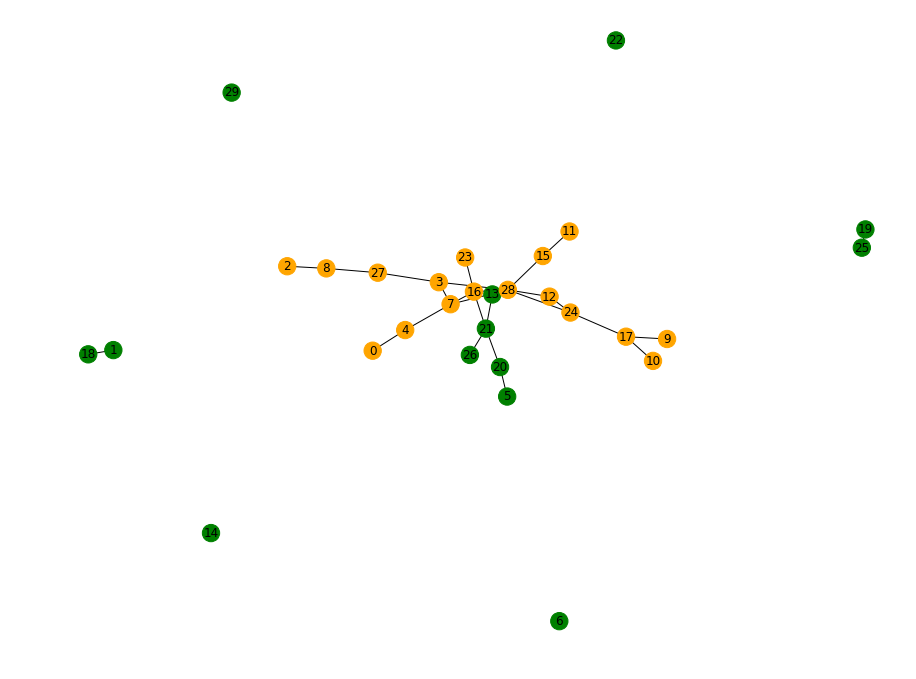

Final Spread of Information


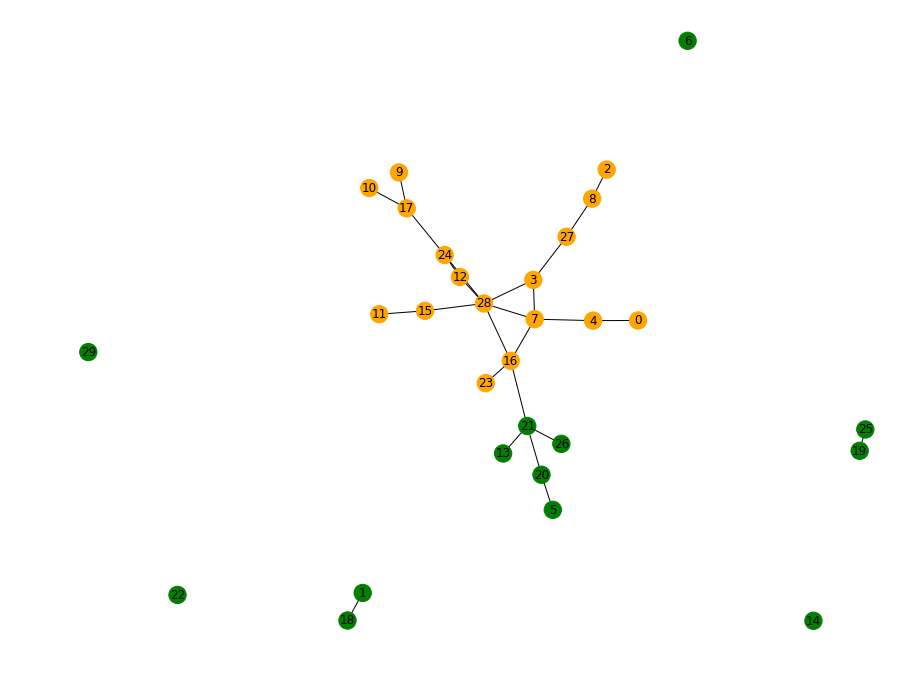

In [1204]:
res = model_information_diffusion(nw_polarisation= 0.5, N=30, opinion_polarisation=0.1, threshold=0.33, niter = 1, viz = 1)


In [1205]:
res

[0.5667]

**Exercise 5:** Study the relationship between Virality and Network Polarisation (P <sub>n</sub>) and Virality (V) over 100 iterations of the model with random graphs. 


Discuss the results of the simulation and how does it relate to the overall phenomena

For a set of runs, **Virality** is defined as fraction of times in these runs that a majority of the nodes are activated. If greater that 50% of the nodes in the network have received the information and believe in it, then the information is considered to have cascaded globally [8] and is measure as viral.


In [1150]:
N_list = range(100, 400, 75) 
nw_polarisation_list = np.linspace(0,1,7) 
threshold_list = np.linspace(0.15,0.4,7)
opinion_polarisation_list = np.linspace(0.0,0.27,5) #range(0.0, 0.27, 0.03) #[0.0, 0.06, 0.12, 0.18, 0.24]
niter = 100

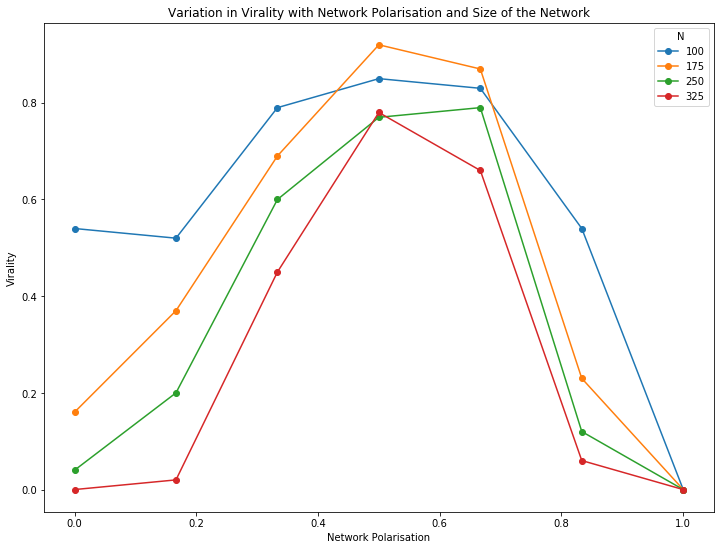

In [1151]:
opinion_polarisation = 0
threshold = 0.27
for N in N_list:
    virality = []
    for nwp in nw_polarisation_list:
        result = model_information_diffusion(nwp, N, opinion_polarisation, threshold, niter)
        spread = sum(i >= 0.5 for i in result) / niter
        virality.append(spread)
    plt.plot(nw_polarisation_list, virality, label=N, marker= 'o')
plt.legend(title='N')
plt.xlabel('Network Polarisation')
plt.ylabel('Virality')
plt.title('Variation in Virality with Network Polarisation and Size of the Network')
plt.show()

**Analysis of Results**

The above graph distinctly indicates the effects of the echo chamber with P<sub>0</sub> = 0. It can be observed that as the size of the graph increases (in terms of number of nodes), the virality of information decreases. This coincides with intuition as well, since a larger network is analogous to greater distribution of people and lesser connections, and hence the information has trouble spreading to every person. 

Another interesting and important observation is that for every value of N, the virality increases with increasing value of network polarisation (P<sub>n</sub>) and then decreases beyond a value of P<sub>n</sub>. As can be seen, the cluster increases the virality until the network polarization passes 0.5-0.7, from which it starts having a negative impact on virality. Since the trend is consistent across different values of N, we can say that the results are robust for different network sizes.


**Exercise 6:** Study the relationship between Virality and Network Polarisation with varying levels of threshold $(\theta)$ 

Discuss the results of the simulation and how does it relate to the overall phenomena

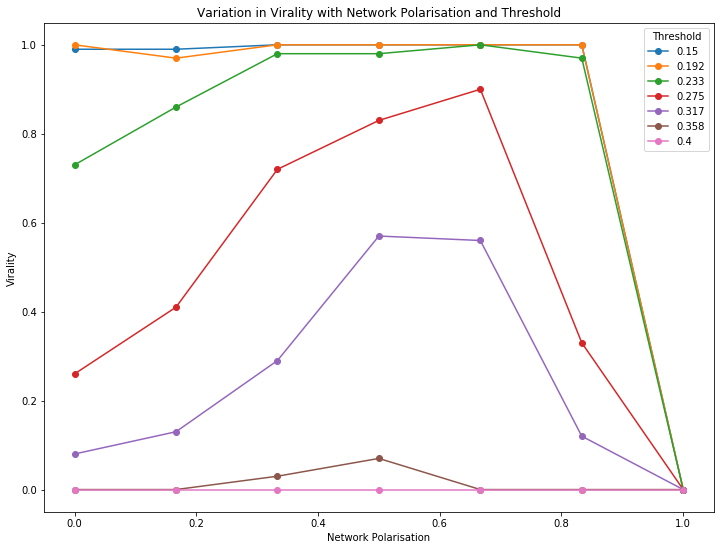

In [1140]:
opinion_polarisation = 0
N = 150
for threshold in threshold_list:
    virality = []
    for nwp in nw_polarisation_list:
        result = model_information_diffusion(nwp, N, opinion_polarisation, threshold, niter)
        spread = sum(i >= 0.5 for i in result)/niter
        virality.append(spread)
    plot(nw_polarisation_list, virality, label=round(threshold, 3), marker='o') 
plt.legend(title='Threshold')
plt.xlabel('Network Polarisation')
plt.ylabel('Virality')
plt.title('Variation in Virality with Network Polarisation and Threshold')
plt.show()

**Analysis of the results** 
The above figure shows the trends in virality as the threshold and network polarisation is varied at P<sub>o</sub>=0. It shows that as the threshold decreases, the virality increases upto a certain value of P<sub>n</sub>, post which we observe a steady decline. This relationship stems from the fact that as the threshold is lowered, the tendency of a person to believe in a piece of information increases, and he then inturn becomes a transmitter of the information, resulting in an information cascade.

All lines ultimately approach zero virality at P<sub>n</sub> = 1, since the echo chamber becomes a disconnected cluster from the rest of the network and there is no way in which information can be transmitted out of the echo chamber. 

**Exercise 7:** Study the relationship between Virality and Threshold $(\theta)$. Introduce opinion polarisation (P<sub>o</sub>) in the echo chamber i.e. reduce the threshold inside the cluster compared to the outside and show how the relationship varies for different values of P<sub>o</sub>.


Discuss the results of the simulation and how does it relate to the overall phenomena

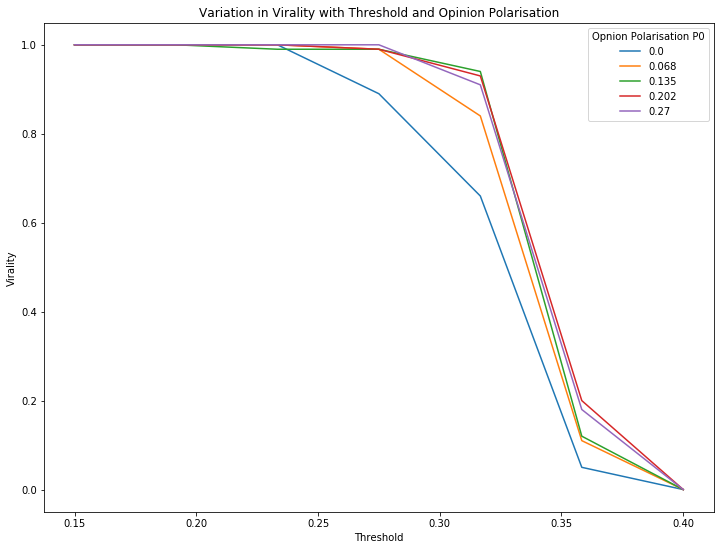

In [1141]:
N = 150
network_polarisation = 0.6
for op in opinion_polarisation_list:
    virality = []
    for threshold in threshold_list:
        result = model_information_diffusion(network_polarisation, N, op, threshold, niter)
        spread = sum(i >= 0.5 for i in result)/niter
        virality.append(spread)
    plot(threshold_list, virality, label= round(op,3), marker = 'o') 
plt.legend(title='Opnion Polarisation Po')
plt.xlabel('Threshold')
plt.ylabel('Virality')
plt.title('Variation in Virality with Threshold and Opinion Polarisation')
plt.show()

**Analysis of Results**
In this section, we are analysisng the effect of opinion polarisation on the spread of information. The slope of the above figure is equally steep for the different settings, but we observe some difference for different values of P<sub>o</sub>. With increasing values of P<sub>o</sub>, there is an increase in virality for the same threshold value uptil a certain value of P<sub>o</sub>, beyond which it stabilies (as P<sub>o</sub> - $\theta$ tend to 0). The graph thus shows how relatively small changes in threshold can result in increased probability for rapid global cascades. In other words, the virality of a narrative is not proportionally related to its quality or resonance, but small differences can have big effects. 

The results go on to show that the effects of an echo chamber are further amplified if the echo chamber is opinion polarised i.e. if people in the echo chamber are more receptive to others in the echo chamber as compared to someone outside it. 





**Exercise 8:** 

**Part a:** Implement a control simulation of the above the setup such that the opinion polarisation effect is applied to random nodes in the network instead of being assigned to nodes in the echo chamber

In [1209]:
def model_information_diffusion_control(nw_polarisation, N, opinion_polarisation, threshold, niter, viz = 0):
    res = []
    for i in range(niter):
        G = nx.erdos_renyi_graph(N, 0.04)
        status = 'healthy'
        nx.set_node_attributes(G, status, 'status')
        nx.set_node_attributes(G, threshold, 'threshold')
        G, echo_chamber = create_echo_chamber(G, nw_polarisation, opinion_polarisation)
        
        ## Reinitialise all nodes to the same threshold value
        nx.set_node_attributes(G, threshold, 'threshold')
        
        ## Select a random set of nodes and decrease their threshold by a factor of Po
        random_node_list_size = int(0.20*G.number_of_nodes())
        random_node_list = random.sample(G.nodes(), random_node_list_size)
        for node in random_node_list:
            G.nodes[node]['threshold'] =  G.nodes[node]['threshold'] - opinion_polarisation
        
        # Start the information diffusion process
        activator_node = random.choice(echo_chamber)
        
        G.nodes[activator_node]['status'] = "activated"
        if(viz == 1):
            print("Start of the Spread of Information")
            draw_activated_nodes(G)
        for neighbor in G.neighbors(activator_node):
            G.nodes[neighbor]['status'] = "activated"
        while True:
            prev_status = nx.get_node_attributes(G, 'status')
            for node in list(G.nodes):
                act_count = 0
                if G.nodes[node]['status'] != "activated":
                    status = nx.get_node_attributes(G, 'status')
                    neighbor_count = len(list(G.neighbors(node)))
                    for neighbor in G.neighbors(node):
                        if status[neighbor] == "activated":
                            act_count = act_count + 1
                    if act_count > (neighbor_count *  G.nodes[node]['threshold'] ) and act_count!=0:
                        G.nodes[node]['status'] = "activated"
            curr_status = nx.get_node_attributes(G, 'status')
            matches = len([i for i, j in zip(prev_status.values(), curr_status.values()) if i == j]) 
            # Stop the diffusion when no change is observed
            if matches == G.number_of_nodes():
                break

        status = nx.get_node_attributes(G, 'status')
        res.append(round(sum( x == 'activated' for x in status.values() )/ N, 4))
    return res


**Exercise 8:** 

**Part b:** Study the relationship between Virality and Network Polarisation. Introduce opinion polarisation (P<sub>o</sub>) in the echo chamber i.e. reduce the threshold inside the cluster compared to the outside and show how the relationship varies for different values of P<sub>o</sub>.

Discuss the results of the simulation and how does it relate to the overall phenomena

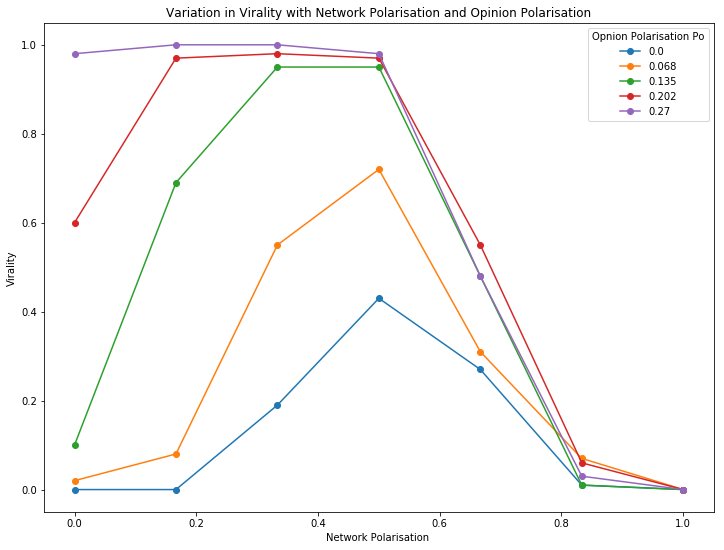

In [1214]:
threshold = 0.33
N =200
for op in opinion_polarisation_list:
    virality = []
    for nwp in nw_polarisation_list:
        result = model_information_diffusion(nwp, N, op, threshold, niter)
        spread = sum(i >= 0.5 for i in result)/niter
        virality.append(spread)
    plot(nw_polarisation_list, virality, label= round(op, 3), marker='o') 
plt.legend(title='Opnion Polarisation Po')
plt.xlabel('Network Polarisation ')
plt.ylabel('Virality')
plt.title('Variation in Virality with Network Polarisation and Opinion Polarisation')
plt.show()

**Analysis of Results**

It is evident that with increase in opinion polarisation (P<sub>0</sub>), there is an increase in virality as P<sub>n</sub> increases upto a certain value (= P<sub>n</sub><sup>c</sup>) beyond which virality decreases. The interesting aspect of this graph is that it shows that the value of P<sub>n</sub><sup>c</sup> is constant with different values of (P<sub>o</sub>), however the level of virality avhieved at the peak increases with increasing values of (P<sub>o</sub>). This suggests that with higher levels of opinion polarization, virality peaks higher for the same value of network polarisation

**Exercise 8:**

**Part c:** Use the control simulation implemented in Exercise 8(a) to compare with the results obtained in Exercise 8(b) i.e. show the difference in results obtained when opinion polarisation occurs in an echo chamber versus when it occurs randomly in any set of nodes in the network

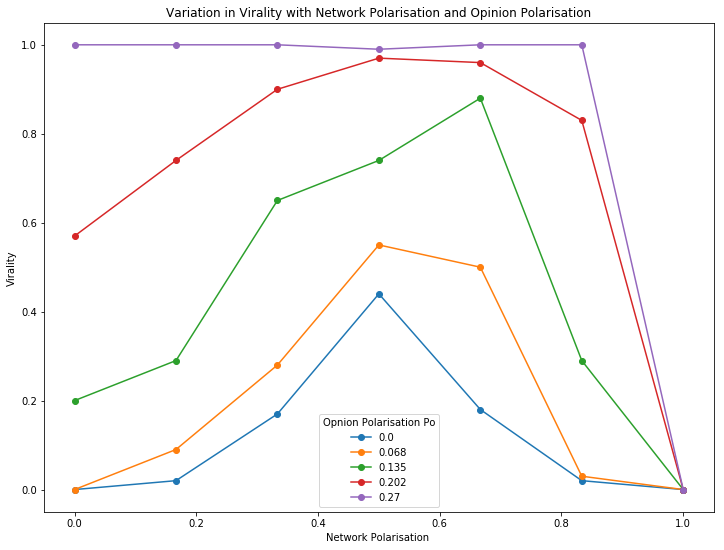

In [1215]:
threshold = 0.33
N =200
for op in opinion_polarisation_list:
    virality = []
    for nwp in nw_polarisation_list:
        result = model_information_diffusion_control(nwp, N, op, threshold, niter)
        spread = sum(i >= 0.5 for i in result)/niter
        virality.append(spread)
    plot(nw_polarisation_list, virality, label= round(op, 3), marker='o') 
plt.legend(title='Opnion Polarisation Po')
plt.xlabel('Network Polarisation ')
plt.ylabel('Virality')
plt.title('Variation in Virality with Network Polarisation and Opinion Polarisation (Control)')
plt.show()

**Analysis of Results**

If we are to compare the two graphs in Ex 8(a) and Ex 8(b), we notice that the value of P<sub>o</sub> effects the value of network polarization that virality peaks, when nodes in the echo chamber are opinion polarised. On the other hand, there is no such effect observed when random nodes in the network are opinion polarised and the peak virality is observed at random values of P<sub>n</sub> (which are greater than the P<sub>n</sub><sup>c</sup> observed in the former graph)


## Conclusion

The general perception is that filter bubble aka echo chambers are detrimental to the propagation of information. This stems from the intuition that connections within such chambers are string ties where as connections outside such chambers are weak ties. Therefore, an information may get increasingly shared and believed within the chamber but is likely to be transmitted outside it. 

The above network model and its repsective simulation proves the opposite, i.e., echo chambers can actually aid in the spread of information (or misinformation) and lead it to become viral. The model shows that certain characterisctics of the network (the network and opinion polarisation) greatly contribute to the impact that echo chambers have in the information diffusion process and even weak ties, if well-connected, can result in a global cascade of information spread. 

One of the key takeaways from the above simulated results is that an opinion polarised echo chamber that has a network polarisation in the range of 0.5-0.7, can rapidly result in the virality of the information. However, if the network polarisation is too high (>0.8), it is likely that the information stays within the cluster and does not propagate to other nodes, leading to a sharp decrease in virality.

From a real-world perspective, closely connected clusters within networks can be dangerous as they mindlessly tend to believe the information being shared by their close peers, without the necessary fact check. Therefore, the last couple of years have seen an unprecedented rise in fake news and a decline in trustworthy news-sources. The effect of such chambers can be monumental ranging from impacting national elections in developed countries to even to triggering mob-lynching in developing countries.


# Work Distribution

In [1258]:
%%html
<style>
table {text-align: left};
</style>





| Team Member Name | Tasks                                                                                          |
|:------------------|--------------------------------------------------------------------------------------------|
| Yiying Pu        | Implementation of Part0-CA-Model & Comparative Analysis  (Part1) |
| Shiqin Zeng       | Modelling, design & silumation Continuous time model of information diffusion along with incorporation of poupulation dynamics(Part 2)                                                         |
| Asra Yousuf      | Implementation of network simulations & Modelling and simulating the effect of echo chambers in spread of misinformation (Part 3)                                                                      |


# References

[1] Zhao, L., Cui, H., Qiu, X., Wang, X. & Wang, J. Sir rumor spreading model in the new media age. Physica A: Statistical Mechanics and its Applications 392, 995–1003, http://www.sciencedirect.com/science/article/pii/S037843711200934X (2013)

[2] Sijuan Ma, Ling Feng, C. Lai, “Mechanistic modelling of viral spreading on empirical social network and popularity prediction”, Scientific Reports.

[3] H. Wang, J.H. Han, L. Deng, K.Q. Cheng, A Class of Rumor Spreading Models with Population Dynamics (2013). Communications in Theoretical Physics, Volume 70, Number 6.

[4]  Dong, Suyalatu & Fan, Feng-Hua & Huang, Yong-Chang, 2018. "Studies on the population dynamics of a rumor-spreading model in online social networks," Physica A: Statistical Mechanics and its Applications, Elsevier, vol. 492(C), pages 10-20.

[5] Echo chambers and viral misinformation: Modeling fake news as complex contagion  Törnberg P (2018) Echo chambers and viral misinformation: Modeling fake news as complex contagion. PLOS ONE 13(9): e0203958.https://doi.org/10.1371/journal.pone.0203958.

[6] J. McAuley and J. Leskovec. Learning to Discover Social Circles in Ego Networks. NIPS, 2012.

[7] Quattrociocchi W, Scala A, Sunstein CR. Echo chambers on facebook. 2016.

[8] Watts DJ. A simple model of global cascades on random networks. Proceedings of the National Academy of Sciences. 2002;99(9):5766–5771.

